# Visualizing nanopore sequencing data using circos plots

In [37]:
# Patient directory
sample = f'GANDALF_CART_before'

In [38]:
# Libraries to process ONT data 
import os
import csv
import pandas as pd
from natsort import natsorted
from scipy.stats import mode
import numpy as np

# Circos libraries 
import pycircos
import collections
import matplotlib.pyplot as plt

In [39]:
# METHYLATION
# Modkit

# Set output directory and find input BED file
outdir = os.path.join(f'data/{sample}/met')
input_bed = os.path.join(outdir, next(f for f in os.listdir(outdir) if f.endswith('.bed')))

# Extract therapy information from the input file name
sid = os.path.basename(input_bed)
therapy = sid.split('_')[-2] + '_' + sid.split('_')[-1].split('.')[0]

# If final CSV files already exist, print a message and skip processing
output_forward = os.path.join(outdir, f'forward_collapsed.csv')
output_reverse = os.path.join(outdir, f'reverse_collapsed.csv')

if os.path.exists(output_forward) and os.path.exists(output_reverse):
    print('Final CSV files already exist.')
    
else:
    # Rename files based on strand and convert BED to CSV file names
    def rename_file(input_path, strand):
        return f"{'forward' if strand == '+' else 'reverse'}.bed"

    def csv_name(bed_file_name):
        return bed_file_name.replace('.bed', '.csv')

    # Extract only "m" methylations and delete mitochondrial data, writing to a temporary file
    temp_file_path = os.path.join(outdir, 'filtered_by_m.bed')
    with open(input_bed, 'r') as input_file, open(temp_file_path, 'w') as temp_file:
        for line in input_file:
            columns = line.strip().split('\t')
            if columns[3] == 'm' and columns[0] != 'chrM':
                temp_file.write(line)

    # Separate data by strand, writing to forward and reverse BED files
    outdir_forward = os.path.join(outdir, rename_file(input_bed, '+'))
    outdir_reverse = os.path.join(outdir, rename_file(input_bed, '-'))
    with open(temp_file_path, 'r') as temp_file, open(outdir_forward, 'w') as output_forward, open(outdir_reverse, 'w') as output_reverse:
        for line in temp_file:
            columns = line.strip().split('\t')
            if columns[5] == '+':
                output_forward.write(line)
            elif columns[5] == '-':
                output_reverse.write(line)

    # Split the last column of the BED files into several columns
    def split_last_column(file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        with open(file_path, 'w') as file:
            for line in lines:
                columns = line.strip().split('\t')
                last_column_split = columns[-1].split()
                columns = columns[:-1] + last_column_split
                file.write('\t'.join(columns) + '\n')

    split_last_column(outdir_forward)
    split_last_column(outdir_reverse)

    # Remove the temporary filtered BED
    os.remove(temp_file_path)

    # Convert BED to CSV format
    def bed_to_csv(bed_file_path, csv_file_path):
        with open(bed_file_path, 'r') as bed_file, open(csv_file_path, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow(['chr', 'start', 'end', 'fraction_modified'])
            
            for line in bed_file:
                columns = line.strip().split('\t')
                chr_column = columns[0]
                start_column = columns[1]
                end_column = columns[2]
                fraction_modified_column = columns[10]  
                
                csv_writer.writerow([chr_column, start_column, end_column, fraction_modified_column])

    csv_forward_path = os.path.join(outdir, csv_name(rename_file(input_bed, '+')))
    csv_reverse_path = os.path.join(outdir, csv_name(rename_file(input_bed, '-')))

    bed_to_csv(outdir_forward, csv_forward_path)
    bed_to_csv(outdir_reverse, csv_reverse_path)

    # Remove intermediate BED files
    os.remove(outdir_forward)
    os.remove(outdir_reverse)

    # Merge consecutive intervals with the same modal methylation value
    def summarize_consecutive_modes(input_df):
        summarized_data = []
        
        for chr_name, group in input_df.groupby('chr'):
            previous_row = group.iloc[0].copy()

            for idx in range(1, len(group)):
                current_row = group.iloc[idx]
                
                if current_row['fraction_modified'] == previous_row['fraction_modified']:
                    previous_row['end'] = current_row['end']

                else:

                    summarized_data.append(previous_row)
                    previous_row = current_row.copy()
                    
            summarized_data.append(previous_row)
        
        return pd.DataFrame(summarized_data)

    # Collapse data into intervals and calculate modal methylation values
    def collapse_intervals(input_csv_path, strand):
        df = pd.read_csv(input_csv_path)
        
        # Sort chromosomes naturally using natsorted
        sorted_chromosomes = natsorted(df['chr'].unique())
        df['chr'] = pd.Categorical(df['chr'], categories=sorted_chromosomes, ordered=True)
        df.sort_values(by=['chr', 'start'], inplace=True)
        
        collapsed_data = []

        for chr_name, group in df.groupby('chr', observed=True):
            group = group.sort_values(by='start')
            start_idx = 0
            while start_idx < len(group):
                start_pos = group.iloc[start_idx]['start']
                end_pos = start_pos + 1000000

                sub_group = group[(group['start'] >= start_pos) & (group['start'] < end_pos)]
                
                if not sub_group.empty:

                    mode_result = mode(sub_group['fraction_modified'])
                    if isinstance(mode_result.mode, np.ndarray):
                        mode_fraction_modified = mode_result.mode[0]
                    else:
                        mode_fraction_modified = mode_result.mode
                    
                    collapsed_data.append({
                        'chr': chr_name,
                        'start': sub_group.iloc[0]['start'],
                        'end': sub_group.iloc[-1]['end'],
                        'fraction_modified': mode_fraction_modified
                    })
                
                start_idx += len(sub_group)

       
        collapsed_df = pd.DataFrame(collapsed_data)
        
        # Summarize consecutive intervals with the same fraction_modified value within each chromosome
        summarized_df = summarize_consecutive_modes(collapsed_df)
        
        # Sort naturally 
        sorted_chromosomes_final = natsorted(summarized_df['chr'].unique())
        summarized_df['chr'] = pd.Categorical(summarized_df['chr'], categories=sorted_chromosomes_final, ordered=True)
        summarized_df.sort_values(by=['chr', 'start'], inplace=True)
        
        # Write the summarized data to a new CSV file
        output_csv_path = os.path.join(outdir, f"{strand}_collapsed.csv")
        summarized_df.to_csv(output_csv_path, index=False)

    # Collapse intervals and calculate modal methylation values for forward and reverse strands
    collapse_intervals(csv_forward_path, 'forward')
    collapse_intervals(csv_reverse_path, 'reverse')



Final CSV files already exist.


In [40]:
# GERMINAL SNPs
# Clair3 data

outdir = os.path.join(f'data/{sample}/SNPs_germ')
input_vcf = os.path.join(outdir, next(f for f in os.listdir(outdir) if f.endswith('.vcf')))
chrom_info_csv = os.path.join('data/hg38_chromosome_general.csv')

output = os.path.join(outdir, 'aggregated_intervals.csv')

# If the output file already exists, print a message and skip processing
if os.path.exists(output):
    print('Final CSV file already exist.')   
else:
    chrom_info = pd.read_csv(chrom_info_csv)

    filtered_rows = []

    with open(input_vcf, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue  # Skip header lines
            columns = line.strip().split('\t')
            if len(columns) >= 7 and columns[6] == 'PASS':
                filtered_rows.append((columns[0], int(columns[1]), columns[6]))

    # Create a DataFrame from the filtered rows
    df = pd.DataFrame(filtered_rows, columns=['cromosoma', 'posición', 'filter'])

    # Create a new DataFrame to store the intervals
    intervals = []

    # Group by chromosome and calculate intervals based on chromosome information
    for chrom, group in df.groupby('cromosoma'):
        # Get the maximum end position of the chromosome from the chromosome information file
        chrom_end = chrom_info.loc[chrom_info['chr'] == chrom, 'end'].values[0]
        
        start = 1
        end = 1000000
        
        while start <= chrom_end:
            count = group[(group['posición'] >= start) & (group['posición'] <= end)].shape[0]
            intervals.append((chrom, start, min(end, chrom_end), count))
            start += 1000000
            end += 1000000

    # Create a new DataFrame from the intervals
    intervals_df = pd.DataFrame(intervals, columns=['chr', 'start', 'end', 'value'])

    # Sort the chromosomes using natsorted for natural order
    intervals_df['chr'] = pd.Categorical(intervals_df['chr'], categories=natsorted(intervals_df['chr'].unique()), ordered=True)
    intervals_df = intervals_df.sort_values(['chr', 'start'])

    # Define the full path of the output CSV file
    output_intervals = os.path.join(outdir, 'aggregated_intervals.csv')

    # Save the intervals DataFrame to a CSV file
    intervals_df.to_csv(output_intervals, index=False)


Final CSV file already exist.


In [41]:
# SOMATIC SNPs
# ClairS

# Define las rutas a los archivos de entrada y salida
outdir = os.path.join(f'data/{sample}/SNPs_som')
input_vcf = os.path.join(outdir, next(f for f in os.listdir(outdir) if f.endswith('.vcf')))
chrom_info_csv = os.path.join('data/hg38_chromosome_general.csv')

output = os.path.join(outdir, 'aggregated_intervals.csv')

output = os.path.join(outdir, 'aggregated_intervals.csv')

if os.path.exists(output):
    print('Final CSV file already exist.')   
else:

    # Leer la información del cromosoma desde el CSV
    chrom_info = pd.read_csv(chrom_info_csv)

    # Lista para almacenar las filas filtradas
    filtered_rows = []

    # Abre y lee el archivo VCF
    with open(input_vcf, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue  # Saltar las líneas de encabezado
            columns = line.strip().split('\t')
            if len(columns) >= 7 and columns[6] == 'PASS':
                # Añadir cromosoma, posición y filtro a la lista
                filtered_rows.append((columns[0], int(columns[1]), columns[6]))


    df = pd.DataFrame(filtered_rows, columns=['cromosoma', 'posición', 'filter'])

    # Crear un nuevo DataFrame para almacenar los intervalos
    intervals = []

    for chrom, group in df.groupby('cromosoma'):
       
        chrom_end = chrom_info.loc[chrom_info['chr'] == chrom, 'end'].values[0]
        
        start = 1
        end = 1000000
        
        while start <= chrom_end:
            count = group[(group['posición'] >= start) & (group['posición'] <= end)].shape[0]
            intervals.append((chrom, start, min(end, chrom_end), count))
            start += 1000000
            end += 1000000

    # Crear un nuevo DataFrame a partir de los intervalos
    intervals_df = pd.DataFrame(intervals, columns=['chr', 'start', 'end', 'value'])

    # Ordenar los cromosomas utilizando natsorted para un orden natural
    intervals_df['chr'] = pd.Categorical(intervals_df['chr'], categories=natsorted(intervals_df['chr'].unique()), ordered=True)
    intervals_df = intervals_df.sort_values(['chr', 'start'])

    # Definir el nombre completo del archivo CSV de salida
    output_intervals = os.path.join(outdir, 'aggregated_intervals.csv')

    # Guardar el DataFrame de intervalos en un archivo CSV
    intervals_df.to_csv(output_intervals, index=False)


Final CSV file already exist.


### Generate the plot:

In [42]:
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

In [43]:
#Set chromosomes
circle = Gcircle() 
with open("data/hg38_chromosome_general.csv") as f:
    f.readline()
    for line in f:
        line   = line.rstrip().split(",") 
        name   = line[0]
        length = int(line[-1]) 
        arc    = Garc(arc_id=name, 
                      size=length,
                      interspace=3, 
                      raxis_range=(960,1000), 
                      labelposition=60, 
                      label_visible=True,
                      facecolor="white") # If no facecolor = rainbow
        circle.add_garc(arc)

<Figure size 800x800 with 0 Axes>

In [44]:
#Patient ID
garc   = Garc(arc_id=None, 
              record=None, 
              interspace=0, 
              linewidth=0, 
              facecolor="#FFFFFF00", 
              raxis_range=(0,30), 
              label=f"{sample}",
              labelsize=24, 
              label_visible=True)

circle.add_garc(garc)
circle.set_garcs()

In [45]:
#Cytoband

# # Rainbow
# color_dict   = {
#     "gneg":"#FFFFFF00", 
#     "gpos25":"#EEEEEE", 
#     "gpos50":"#BBBBBB", 
#     "gpos75":"#777777", 
#     "gpos100":"#000000", 
#     "gvar":"#FFFFFF00", 
#     "stalk":"#C01E27", 
#     "acen":"#D82322"
# }

# BN
color_dict = {
    "gneg": "#FFFFFF",   
    "gpos25": "#DDDDDD", 
    "gpos50": "#BBBBBB", 
    "gpos75": "#777777", 
    "gpos100": "#333333",
    "gvar": "#AAAAAA",   
    "stalk": "#999999",  
    "acen": "#D82322"    
}

arcdata_dict = collections.defaultdict(dict)
with open("data/hg38_chromosome_cytoband.csv") as f:
    f.readline()
    for line in f:
        line  = line.rstrip().split(",")
        name  = line[0]     
        start = int(line[1])-1 
        width = int(line[2])-(int(line[1])-1) 
        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["widths"]    = [] 
            arcdata_dict[name]["colors"]    = [] 
        arcdata_dict[name]["positions"].append(start) 
        arcdata_dict[name]["widths"].append(width)
        arcdata_dict[name]["colors"].append(color_dict[line[-1]])

for key in arcdata_dict:
    circle.barplot(key,
                   data=[1]*len(arcdata_dict[key]["positions"]), 
                   positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], 
                   raxis_range=[960,999], 
                   facecolor=arcdata_dict[key]["colors"])     

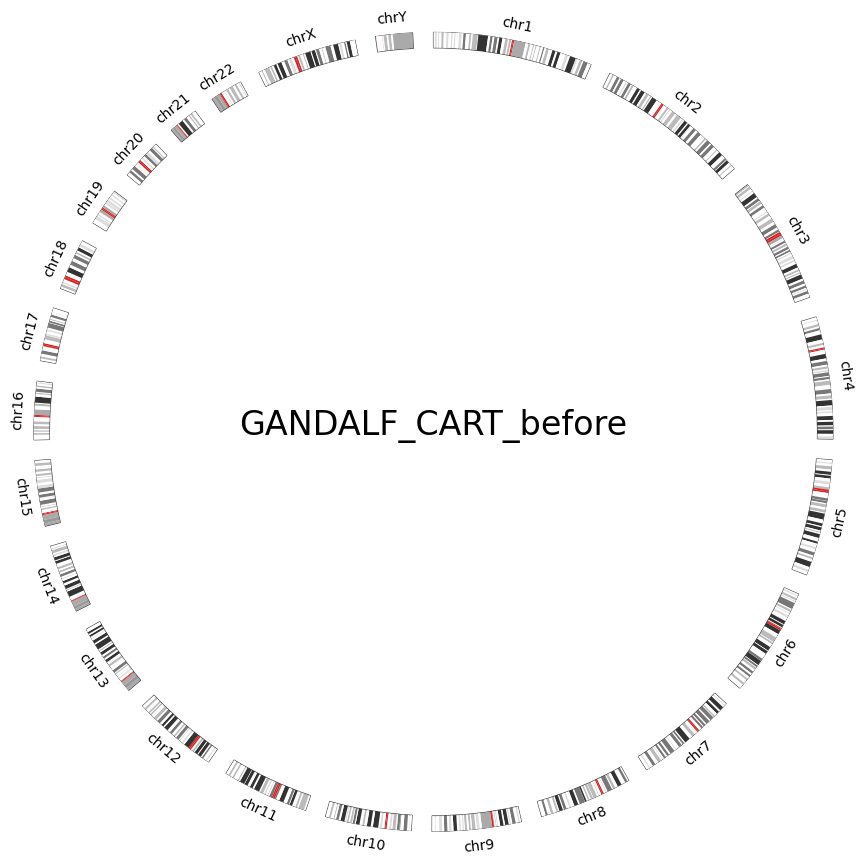

In [46]:
circle.figure

In [47]:
#Methylation_forward

values_all   = [] 
arcdata_dict = collections.defaultdict(dict)
with open(f"data/{sample}/met/forward_collapsed.csv") as f:
    f.readline()
    for line in f:
        line  = line.rstrip().split(",")
        name  = line[0]     
        start = int(line[1])-1
        end   = int(line[2]) 
        width = end-start 
        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["widths"]    = [] 
            arcdata_dict[name]["values"]    = [] 
        arcdata_dict[name]["positions"].append(start) 
        arcdata_dict[name]["widths"].append(width)
        arcdata_dict[name]["values"].append(float(line[-1]))
        values_all.append(float(line[-1]))

vmin, vmax = min(values_all), max(values_all) 
for key in arcdata_dict:
    circle.heatmap(key, 
                   data=arcdata_dict[key]["values"], 
                   positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], 
                   raxis_range=[870,920], 
                   vmin=vmin, 
                   vmax=vmax, 
                   cmap=plt.cm.Blues )

In [48]:
#Methylation_reverse

values_all   = [] 
arcdata_dict = collections.defaultdict(dict)
with open(f"data/{sample}/met/reverse_collapsed.csv") as f:
    f.readline()
    for line in f:
        line  = line.rstrip().split(",")
        name  = line[0]     
        start = int(line[1])-1
        end   = int(line[2]) 
        width = end-start 
        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["widths"]    = [] 
            arcdata_dict[name]["values"]    = [] 
        arcdata_dict[name]["positions"].append(start) 
        arcdata_dict[name]["widths"].append(width)
        arcdata_dict[name]["values"].append(float(line[-1]))
        values_all.append(float(line[-1]))

vmin, vmax = min(values_all), max(values_all) 
for key in arcdata_dict:
    circle.heatmap(key, 
                   data=arcdata_dict[key]["values"], 
                   positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], 
                   raxis_range=[820,870], 
                   vmin=vmin, 
                   vmax=vmax, 
                   cmap=plt.cm.Reds )

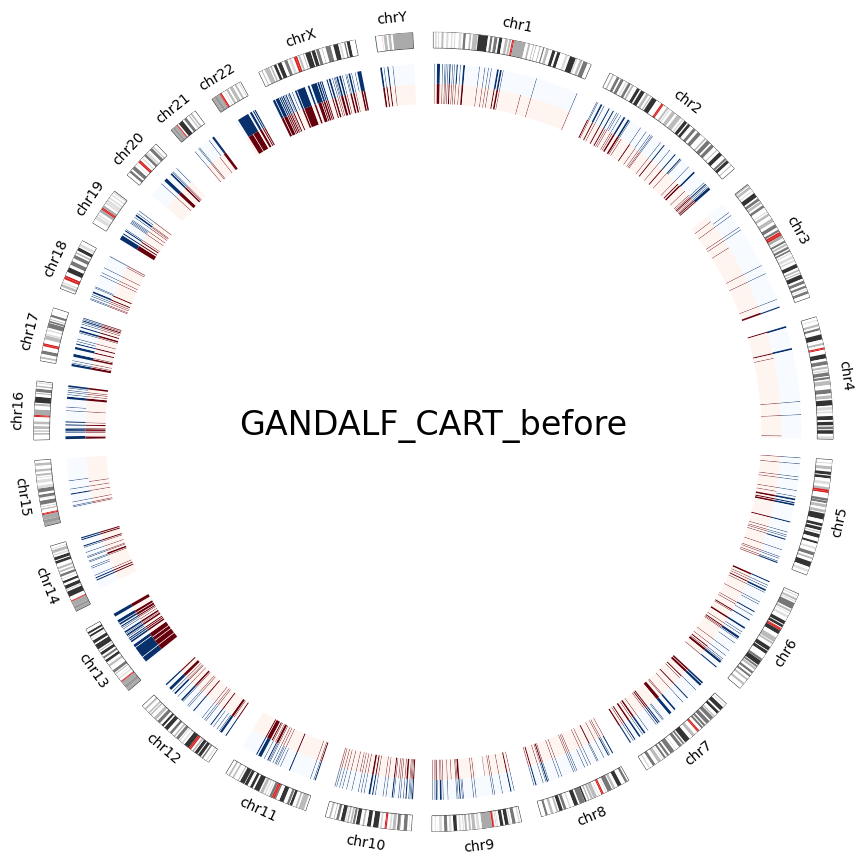

In [49]:
circle.figure

In [50]:
# # Germinal SNPs

# values_all   = [] 
# arcdata_dict = collections.defaultdict(dict)
# with open(f"data/{sample}/SNPs_germ/aggregated_intervals.csv") as f:
#     f.readline()
#     for line in f:
#         line  = line.rstrip().split(",")
#         name  = line[0]     
#         start = int(line[1])-1
#         end   = int(line[2]) 
#         mid   = (start+end)/2
#         value = float(line[-1]) 
#         values_all.append(value) 
#         if name not in arcdata_dict:
#             arcdata_dict[name]["positions"] = []
#             arcdata_dict[name]["values"] = []
#         arcdata_dict[name]["positions"].append(mid) 
#         arcdata_dict[name]["values"].append(value)
    
# vmin, vmax = min(values_all), max(values_all) 
# for key in arcdata_dict:
#     circle.lineplot(key, 
#                     data=arcdata_dict[key]["values"], 
#                     positions=arcdata_dict[key]["positions"], 
#                     rlim=[vmin-0.05*abs(vmin), 
#                           vmax+0.05*abs(vmax)], 
#                     raxis_range=(500,740), 
#                     linecolor="grey", 
#                     spine=False) 

In [51]:
# Somatic SNPs

values_all   = [] 
arcdata_dict = collections.defaultdict(dict)
with open(f"data/{sample}/SNPs_som/aggregated_intervals.csv") as f:
    f.readline()
    for line in f:
        line  = line.rstrip().split(",")
        name  = line[0]     
        start = int(line[1])-1
        end   = int(line[2]) 
        mid   = (start+end)/2
        value = float(line[-1]) 
        values_all.append(value) 
        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["values"] = []
        arcdata_dict[name]["positions"].append(mid) 
        arcdata_dict[name]["values"].append(value)

vmin, vmax = min(values_all), max(values_all) 
for key in arcdata_dict:
    circle.lineplot(key, 
                    data=arcdata_dict[key]["values"], 
                    positions=arcdata_dict[key]["positions"], 
                    rlim=[vmin-10-0.05*abs(vmin), 
                          vmax+0.05*abs(vmax)], 
                    raxis_range=(680, 780), 
                    linecolor="forestgreen", 
                    spine=True) 

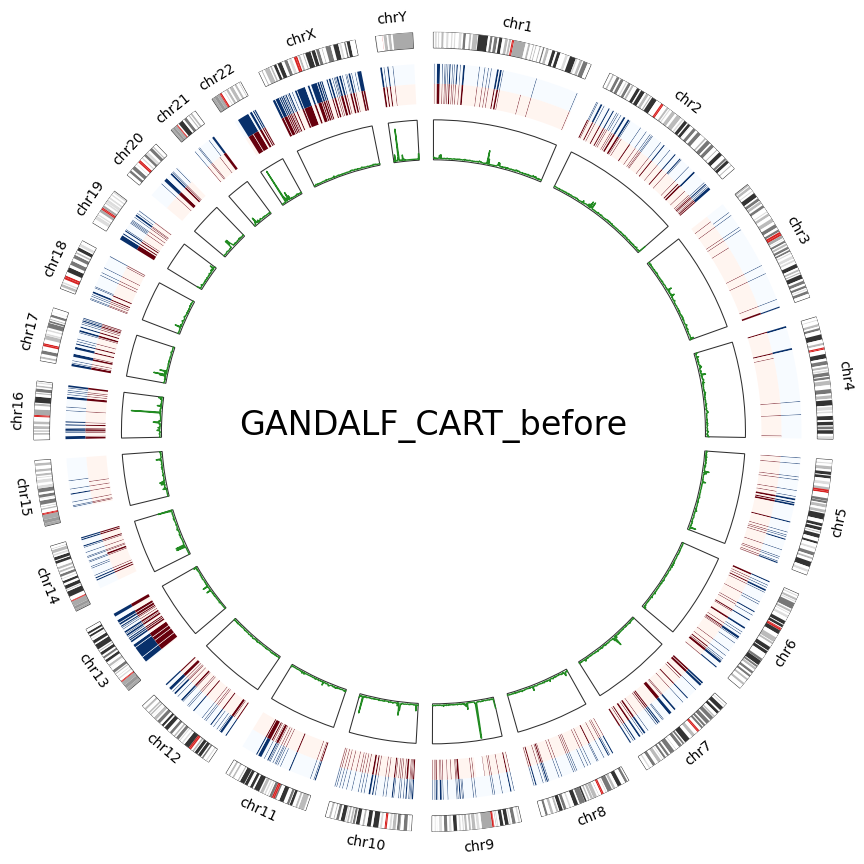

In [52]:
circle.figure

In [53]:
circle.figure.savefig(f"results/{sample}.pdf", 
                      bbox_inches='tight', 
                      pad_inches=0.1)